# Model's solution check

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model_optimized import PINN

In [12]:
MODEL_PATH = Path('models')
MODEL_NAME = "2D_steady_model_optimized.pth"
MODEL_LOAD_PATH = MODEL_PATH / MODEL_NAME

## Defining models parameters

In [13]:
x_start = 0; x_end = 2.2   # x-length
y_start = 0; y_end = 0.41  # y-lenght
t_start = 0; t_end = 0    # t_lenght
xc = 0.4; yc = 0.2; rr = 0.05  # circle-coordinates
D = 2*rr
rho = 1000  # density
nu = 1e-4   # kinematic viscosity
U_max = 0.05 # current maximum velocity
n_interior = 5000  # interior points
n_boundary = 1000   # boundary points
x_domain = torch.tensor([x_start,x_end])
y_domain = torch.tensor([y_start,y_end])
t_domain = torch.tensor([t_start,t_end])
circle_coordinates = torch.tensor([xc,yc,rr])
distance = torch.tensor([2 * rr])  # distance from the center for extra sampling
properties = torch.tensor([rho,nu,U_max])
number_intervals = torch.tensor([10])   # time intervals
n_points = torch.tensor([n_interior,n_boundary])

device = 'cpu'  #'cuda' if torch.cuda.is_available() else 'cpu'
num_input = 2; num_output = 3; num_layers = 3; num_neurons = 256
sigma_x = 10; sigma_y = 10
mu = 0.5; std = 0.1
epsilon = 1
lambda_frequency = 500
alpha = 0.9

network_parameters = torch.tensor([num_input,num_output,num_layers,num_neurons])
fourier_features_parameters = torch.tensor([sigma_x,sigma_y])
random_weight_initialization_parameters = torch.tensor([mu,std])
other_hyperparameters = torch.tensor([epsilon,lambda_frequency,alpha])

In [14]:
steady_NS = PINN(network_parameters,
              fourier_features_parameters,
              x_domain,
              y_domain,
              circle_coordinates,
              properties,
              random_weight_initialization_parameters,
              device)

## Loading the weights

In [15]:
steady_NS.load_state_dict(torch.load(f=MODEL_LOAD_PATH,map_location=device))

C:\Users\andre\AppData\Local\Temp\ipykernel_22172\1159097074.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steady_NS.load_state_dict(torch.load(f=MODEL_LOAD_PATH,map_l

<All keys matched successfully>

## Coordinate vectors

In [63]:
n_slices = 500
xx = torch.linspace(0,x_end/D,n_slices); yy = torch.linspace(0,y_end/D,n_slices)
x_grid, y_grid = torch.meshgrid(xx,yy,indexing='xy')
x_grid = x_grid.reshape(-1,1); y_grid = y_grid.reshape(-1,1)
mask_tensor = (x_grid*D - xc)**2 + (y_grid*D - yc)**2 >= rr**2
x_pinn = x_grid[mask_tensor].reshape(-1,1); y_pinn = y_grid[mask_tensor].reshape(-1,1)
U = torch.full_like(x_grid,float('nan'))
V = torch.full_like(x_grid,float('nan'))
P = torch.full_like(x_grid,float('nan'))

X = x_grid.reshape(n_slices,n_slices)*D
Y = y_grid.reshape(n_slices,n_slices)*D

dx = xx[1] - xx[0]
dy = yy[1] - yy[0]

In [57]:
steady_NS.eval()
with torch.no_grad():
    u,v,p = steady_NS(x_pinn,y_pinn)

U[mask_tensor] = u.squeeze()
V[mask_tensor] = v.squeeze()
P[mask_tensor] = p.squeeze()

U_plot = (U.reshape(n_slices,n_slices) * U_max).numpy()
V_plot = (V.reshape(n_slices,n_slices) * U_max).numpy()
P_plot = (P.reshape(n_slices,n_slices) * U_max**2 * rho).numpy()

## U - velocity plot

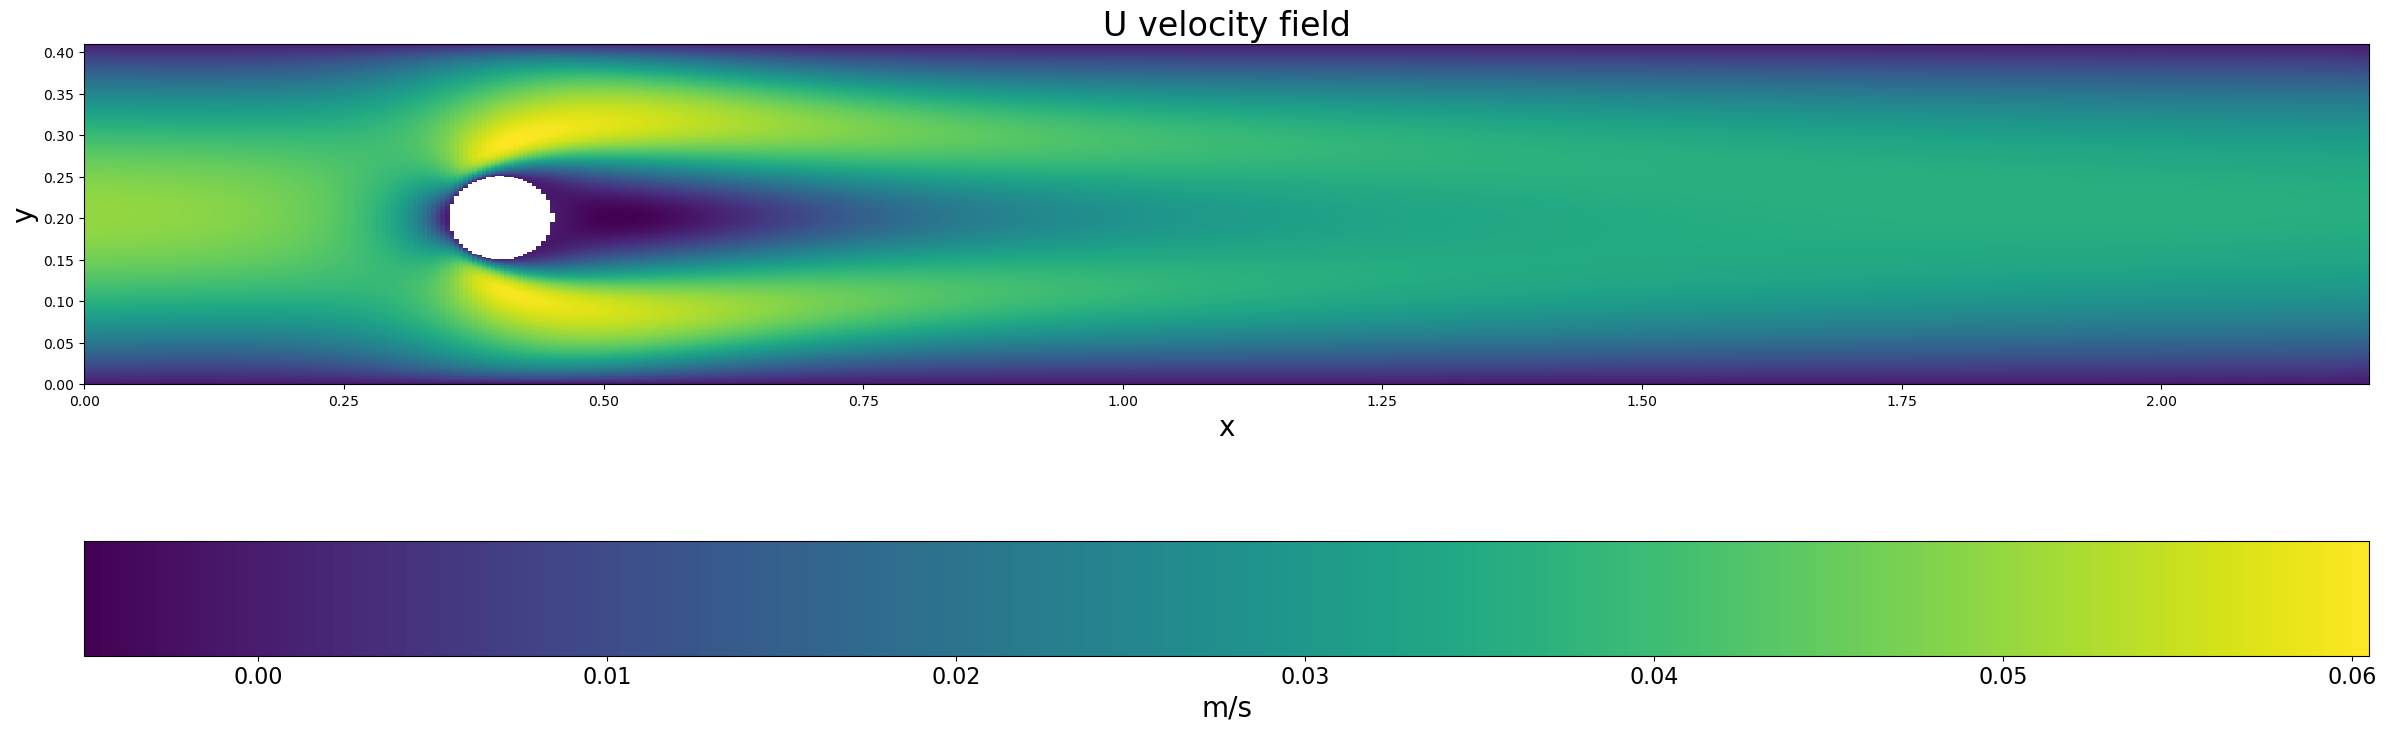

In [58]:
plt.figure(figsize=(24,16))
im = plt.imshow(U_plot, origin='lower', interpolation='nearest', extent=(0,x_end,0,y_end))

# Colorbar sotto
cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
cbar.set_label("m/s", fontsize=20)  # aumenta font label colorbar
cbar.ax.tick_params(labelsize=16)    # aumenta font dei numeri sulla colorbar

# Titolo e assi
plt.title('U velocity field', fontsize=24)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)

# Aspect ratio
plt.gca().set_aspect((20*D)/(25*D))
plt.tight_layout()
plt.show()

## V - velocity plot

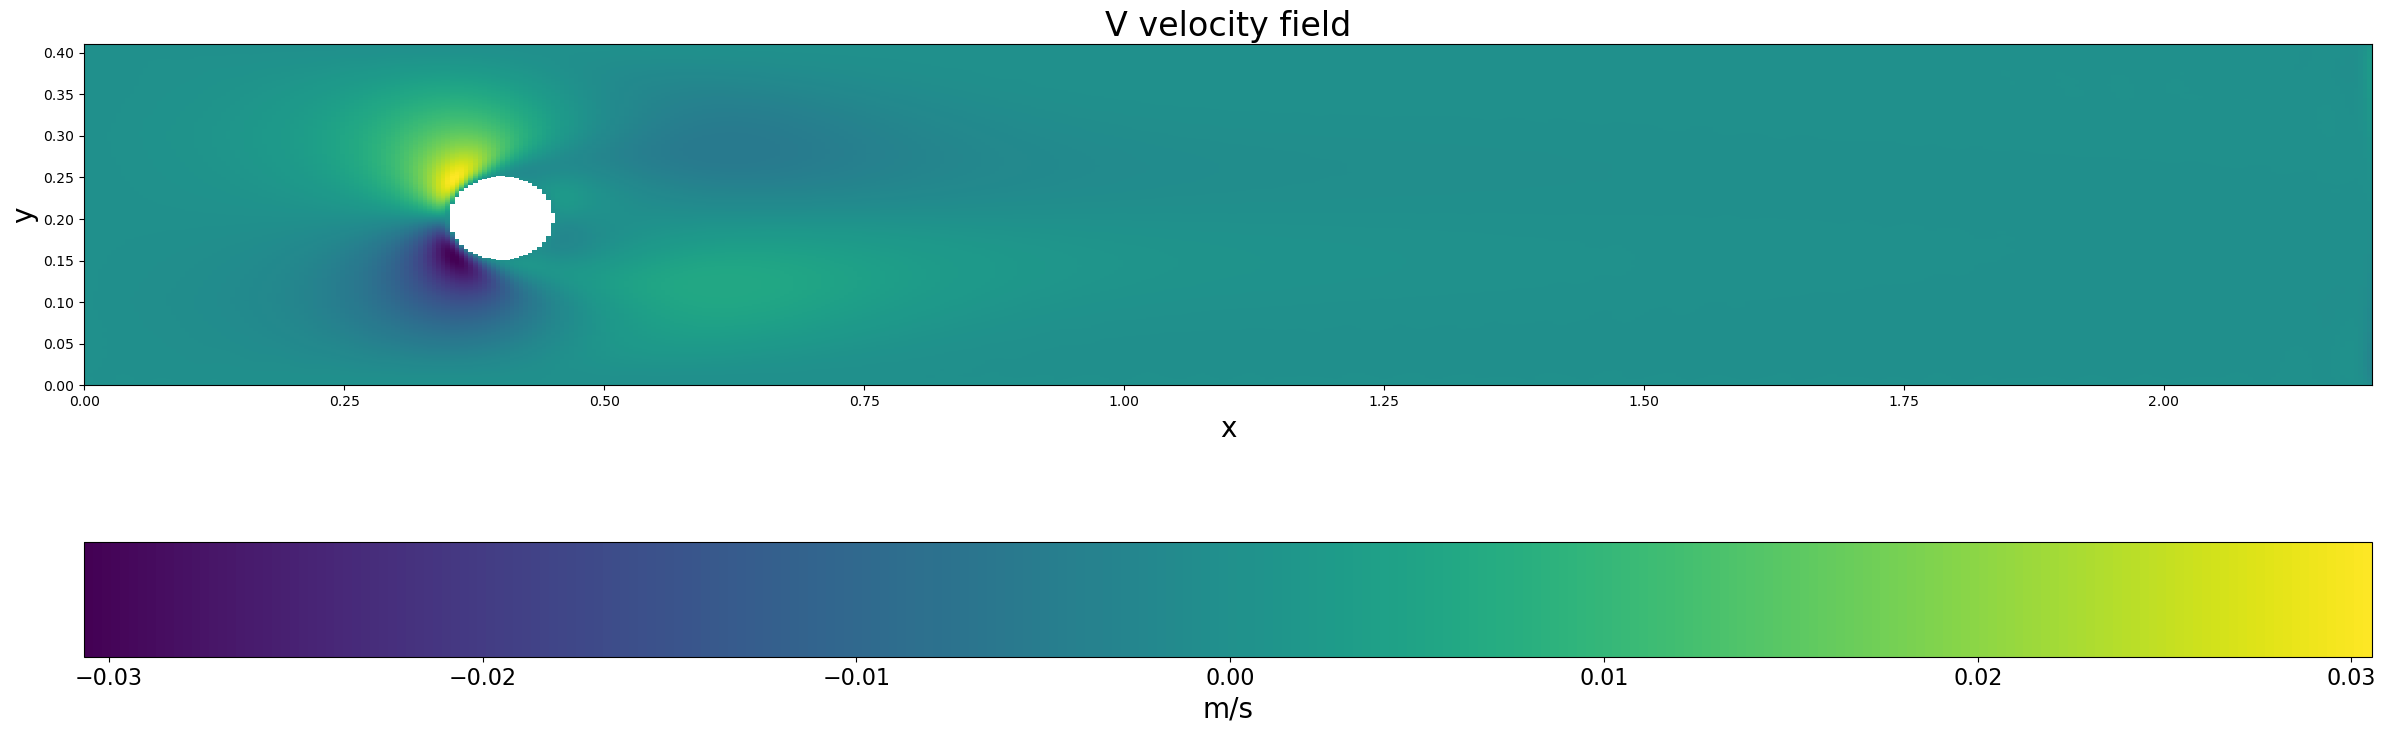

In [59]:
plt.figure(figsize=(24,16))
im = plt.imshow(V_plot, origin='lower', interpolation='nearest', extent=(0,x_end,0,y_end))

# Colorbar sotto
cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
cbar.set_label("m/s", fontsize=20)  # aumenta font label colorbar
cbar.ax.tick_params(labelsize=16)    # aumenta font dei numeri sulla colorbar

# Titolo e assi
plt.title('V velocity field', fontsize=24)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)

# Aspect ratio
plt.gca().set_aspect((20*D)/(25*D))
plt.tight_layout()
plt.show()

## Velocity plot

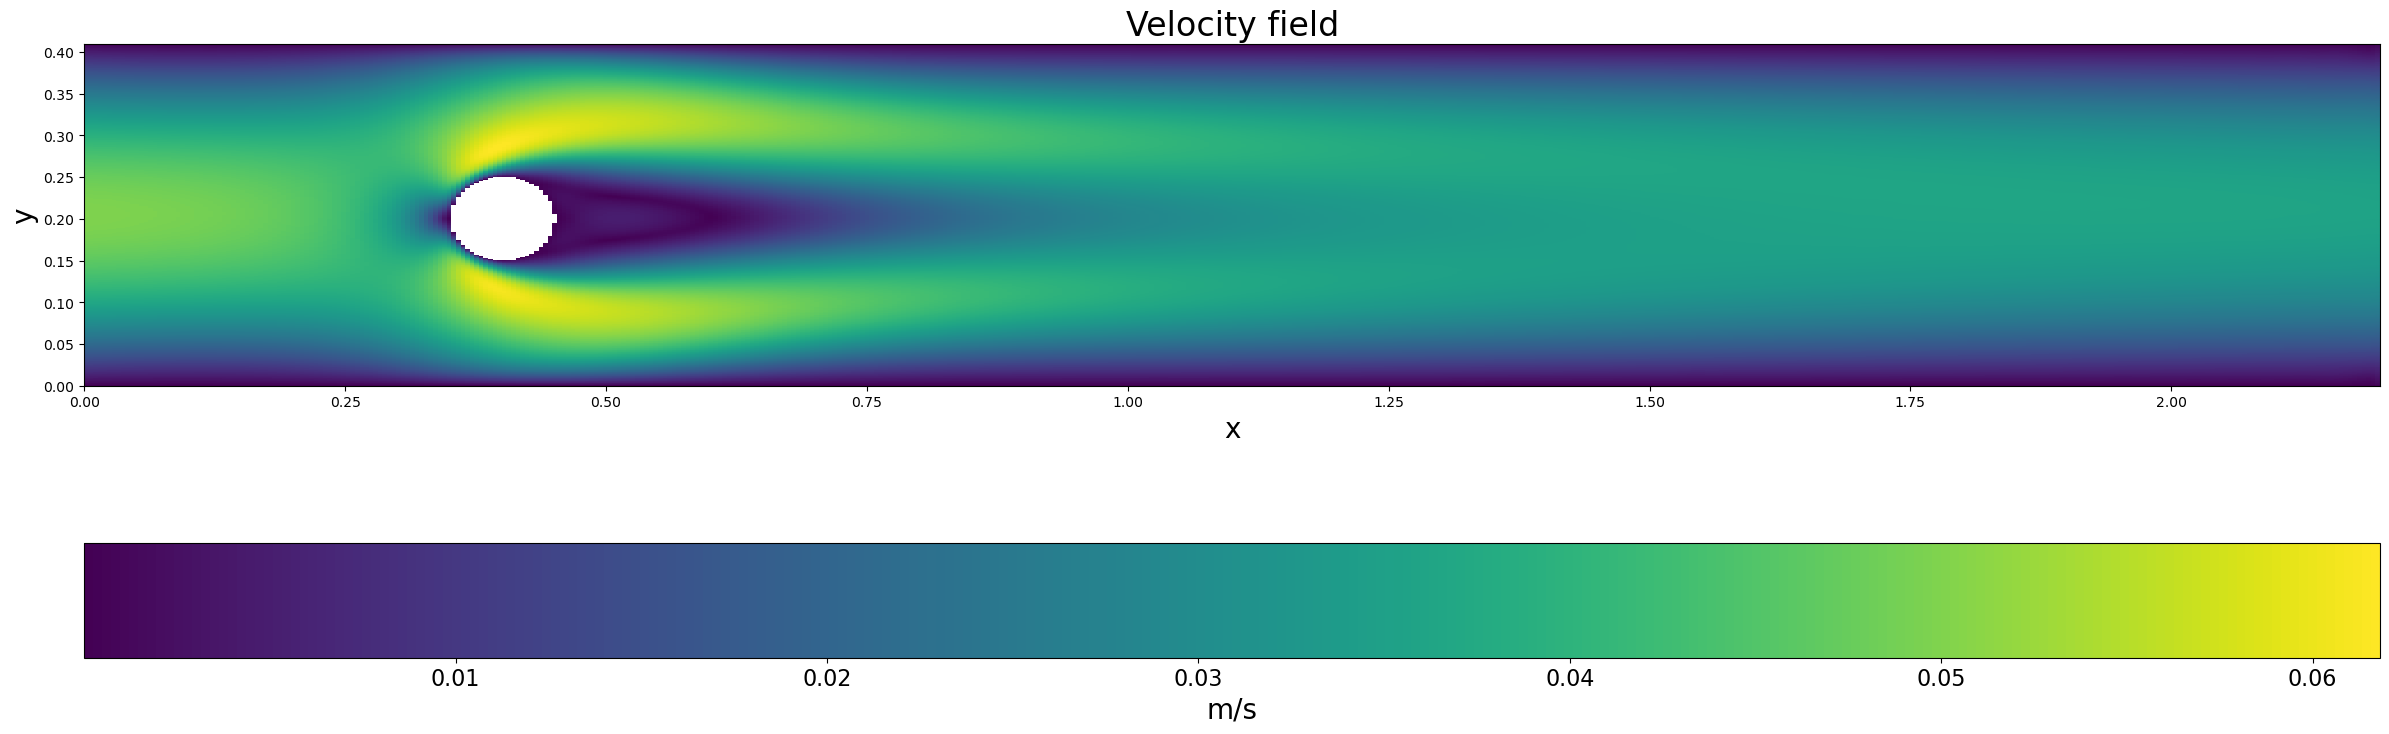

In [60]:
Velocity_plot = np.sqrt(U_plot**2 + V_plot**2)
plt.figure(figsize=(24,16))
im = plt.imshow(Velocity_plot, origin='lower', interpolation='nearest', extent=(0,x_end,0,y_end))

# Colorbar sotto
cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
cbar.set_label("m/s", fontsize=20)  # aumenta font label colorbar
cbar.ax.tick_params(labelsize=16)    # aumenta font dei numeri sulla colorbar

# Titolo e assi
plt.title('Velocity field', fontsize=24)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)

# Aspect ratio
plt.gca().set_aspect((20*D)/(25*D))
plt.tight_layout()
plt.show()

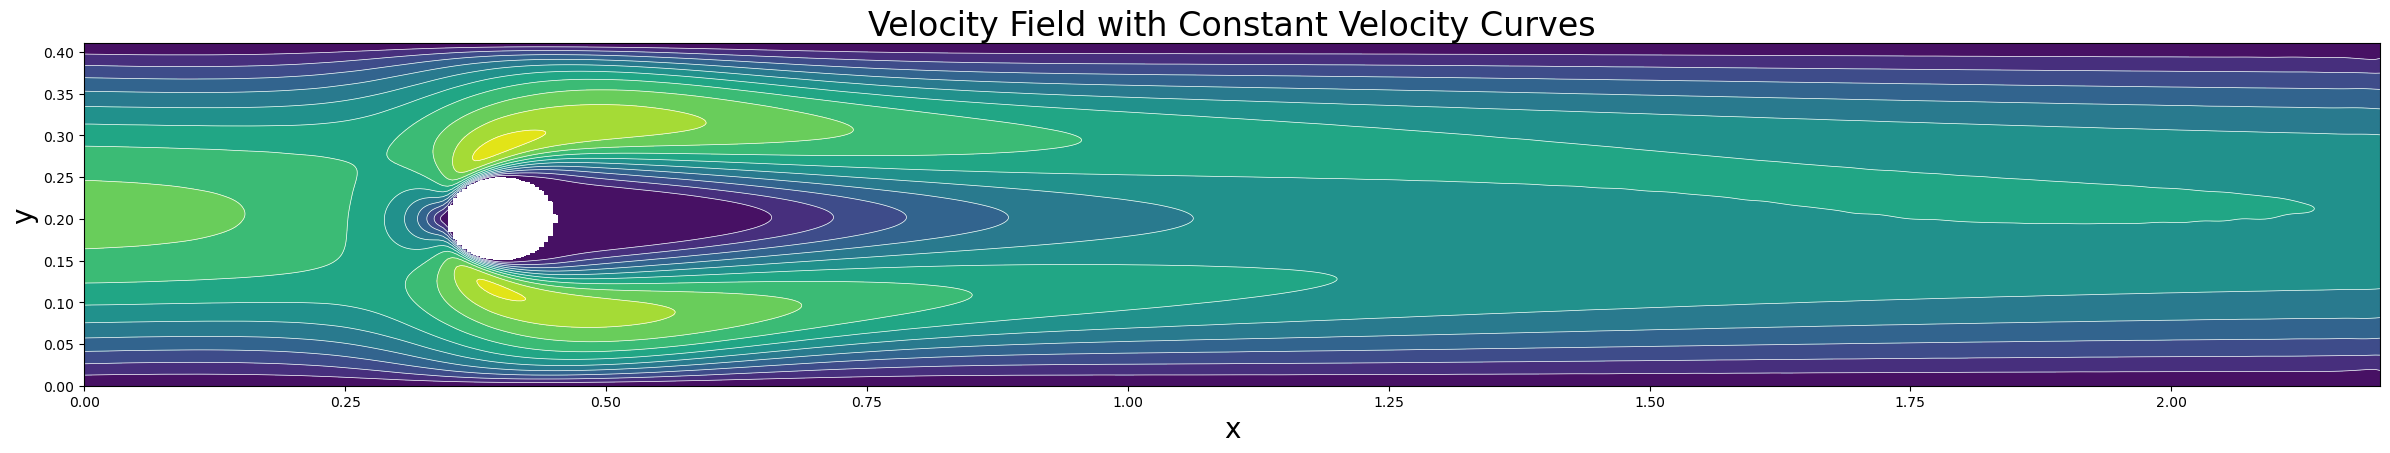

In [61]:
plt.figure(figsize=(24,16))

# Colormap piena (opzionale, puoi togliere se vuoi solo le linee)
plt.contourf(
    X,
    Y,
    Velocity_plot,
    levels=10,
    cmap='viridis'
)

# Curve di velocità costante (linee sottili, senza etichette)
contours = plt.contour(
    x_grid.reshape(n_slices,n_slices)*D,
    y_grid.reshape(n_slices,n_slices)*D,
    Velocity_plot,
    levels=10,
    colors='white',
    linewidths=0.5  # linee più sottili
)

# Non vogliamo le etichette sulle curve → togliamo plt.clabel
# plt.clabel(contours, inline=True, fontsize=10, fmt="%.2f")

# Nessuna colorbar
# plt.colorbar(label="Velocity (m/s)")

plt.title("Velocity Field with Constant Velocity Curves",fontsize=24)
plt.xlabel("x",fontsize=20)
plt.ylabel("y",fontsize=20)

# Aspect ratio
plt.gca().set_aspect((20*D)/(25*D))
plt.tight_layout()
plt.show()

## Continuity

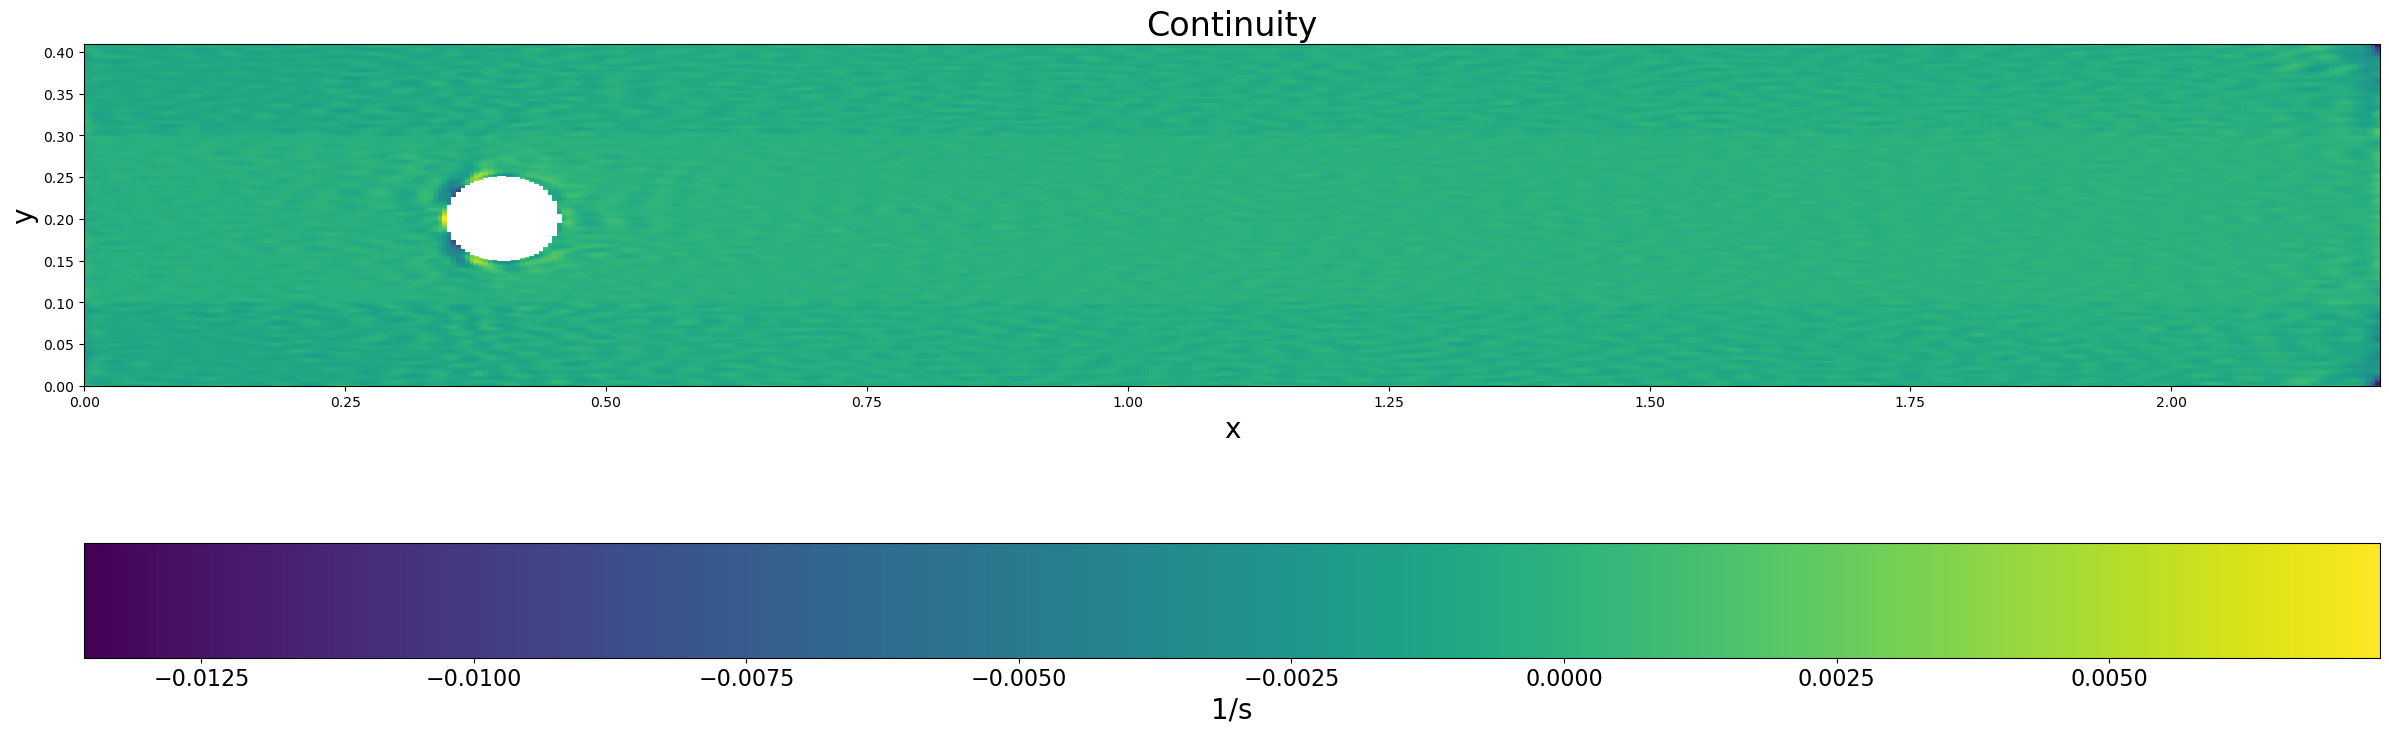

In [66]:
Ux = np.gradient(U_plot,dx,axis=1,edge_order=2)
Vy = np.gradient(V_plot,dy,axis=0,edge_order=2)
Continuity = Ux + Vy

plt.figure(figsize=(24,16))
im = plt.imshow(Continuity, origin='lower', interpolation='nearest', extent=(0,x_end,0,y_end))

# Colorbar sotto
cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
cbar.set_label("1/s", fontsize=20)  # aumenta font label colorbar
cbar.ax.tick_params(labelsize=16)    # aumenta font dei numeri sulla colorbar

# Titolo e assi
plt.title('Continuity', fontsize=24)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)

# Aspect ratio
plt.gca().set_aspect((20*D)/(25*D))
plt.tight_layout()
plt.show()

## Inlet and outlet velocity profile

The error on the mass conservation is : 0.036162689328193665


C:\Users\andre\AppData\Local\Temp\ipykernel_22172\3786248776.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  error = np.abs(mass_flow_in - mass_flow_out)


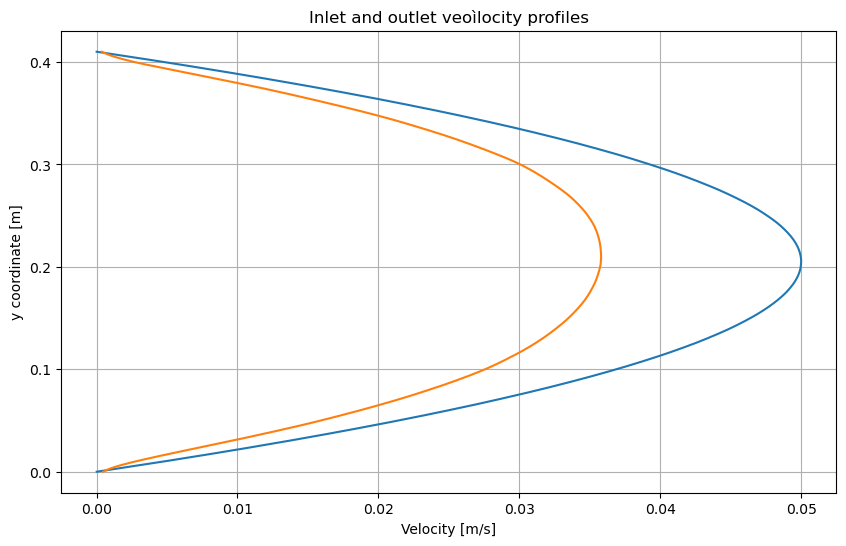

In [81]:
plt.figure(figsize=(10,6))

plt.plot(U_plot[:,0],yy*D,label='Inlet')
plt.plot(U_plot[:,-1],yy*D,label='Outlet')
plt.title('Inlet and outlet veoìlocity profiles')
plt.xlabel('Velocity [m/s]')
plt.ylabel('y coordinate [m]')
plt.grid(True)

mass_flow_in = dy * np.sum(U_plot[:,0])
mass_flow_in

mass_flow_out = dy * np.sum(U_plot[:,-1])
mass_flow_out

error = np.abs(mass_flow_in - mass_flow_out)
print(f'The error on the mass conservation is : {error}')

## Pressure

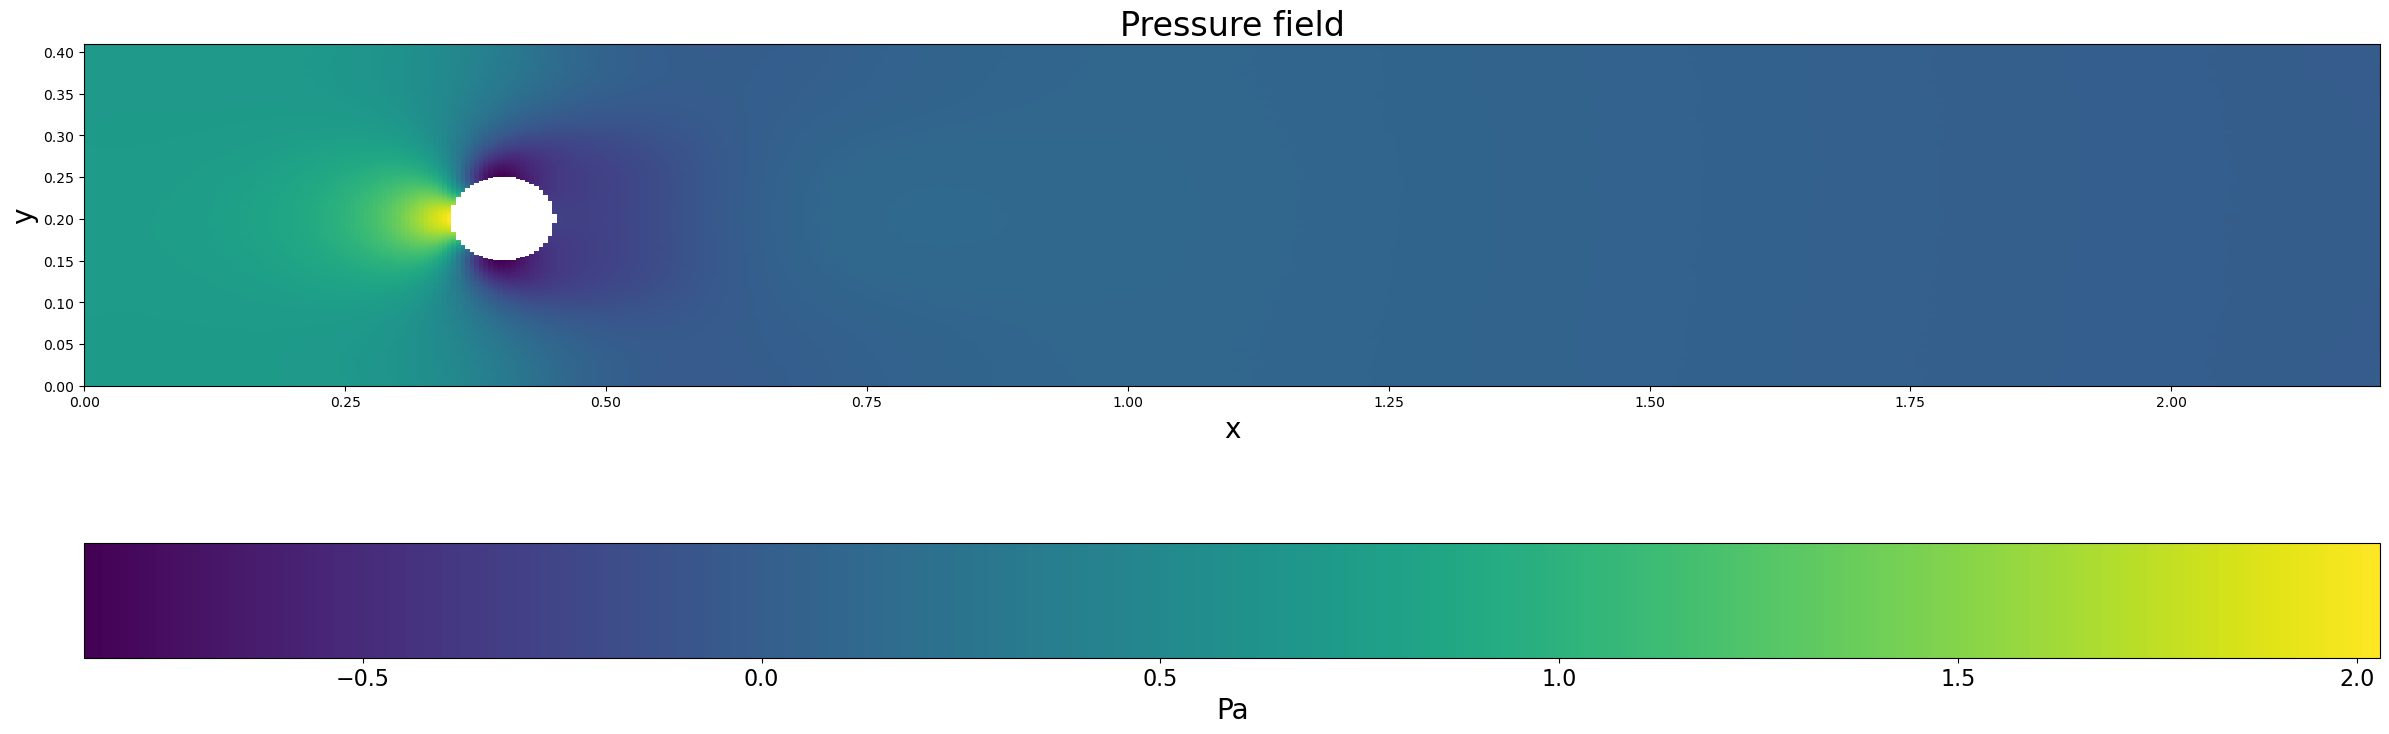

In [82]:
plt.figure(figsize=(24,16))
im = plt.imshow(P_plot, origin='lower', interpolation='nearest', extent=(0,x_end,0,y_end))

# Colorbar sotto
cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
cbar.set_label("Pa", fontsize=20)  # aumenta font label colorbar
cbar.ax.tick_params(labelsize=16)    # aumenta font dei numeri sulla colorbar

# Titolo e assi
plt.title('Pressure field', fontsize=24)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)

# Aspect ratio
plt.gca().set_aspect((20*D)/(25*D))
plt.tight_layout()
plt.show()